# ARIMA -- tease out cycles 
Assume user downloaded archive.zip from Kaggle,
renamed the file BuildingData.zip,
and stored the file in the data subdirectory.
Assume the zip file contains the weather.csv file.  

In [1]:
DATAPATH=''
try:
    # On Google Drive, set path to my drive / data directory.
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    # On home computer, set path to local data directory.
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"

ZIP_FILE='BuildingData.zip'
ZIP_PATH = DATAPATH+ZIP_FILE
STEAM_FILE='steam.csv'
WEATHER_FILE='weather.csv'
MODEL_FILE='Model'  # will be used later to save models

In [2]:
from os import listdir
import csv
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [3]:
def read_zip_to_panda(zip_filename,csv_filename):
    zip_handle = ZipFile(zip_filename)
    csv_handle = zip_handle.open(csv_filename)
    panda = pd.read_csv(csv_handle)
    return panda
def fix_date_type(panda):
    # Convert the given timestamp column to the pandas datetime data type.
    panda['timestamp'] = pd.to_datetime(panda['timestamp'], infer_datetime_format = True)
    indexed = panda.set_index(['timestamp'])
    return indexed
def get_site_timeseries(panda,site):
    # Assume the panda dataframe has a datetime column.
    # (If not, call fix_date_type() before this.)
    # Extract the timeseries for one site.
    # Convert the datetime column to a DatetimeIndex.
    site_df = panda[panda['site_id']==site]
    temp_col = site_df['date']
    temp_val = temp_col.values
    temp_ndx = pd.DatetimeIndex(temp_val)
    dropped = site_df.drop('date',axis=1)
    panda = dropped.set_index(temp_ndx)
    return panda

In [4]:
SITE = 'Eagle'
METER = 'steam'
BLDG = 'Eagle_education_Peter'
wet_df = read_zip_to_panda(ZIP_PATH,WEATHER_FILE)
wet_df = fix_date_type(wet_df)
stm_df = read_zip_to_panda(ZIP_PATH,STEAM_FILE)
stm_df = fix_date_type(stm_df)
site_specific_weather = wet_df.loc[wet_df['site_id'] == SITE]
all_buildings = [x for x in stm_df.columns if x.startswith(SITE)]

In [5]:
DOWNSAMPLE = False   
def smooth(df):
    # For smoothing the 24 hour cycle, we do not want exponential smoothing.
    smoothed = None
    if DOWNSAMPLE:
        # This alternate method samples down to 1/24 time steps.
        smoothed = df.resample("24H").mean() 
    else:
        # This method does not reduce the number of time steps.
        # Note the first 23 measurements get set to Nan.
        smoothed=df.rolling(window=24).mean()
        smoothed=smoothed[24:]
    return smoothed


In [6]:
stm_df[[BLDG]]

,Eagle_education_Peter
timestamp,
2016-01-01 00:00:00,2494.8017
2016-01-01 01:00:00,2647.4861
2016-01-01 02:00:00,2642.3082
2016-01-01 03:00:00,2803.3292
2016-01-01 04:00:00,2725.3192
...,...
2017-12-31 19:00:00,7041.5076
2017-12-31 20:00:00,6940.1219
2017-12-31 21:00:00,7015.1232


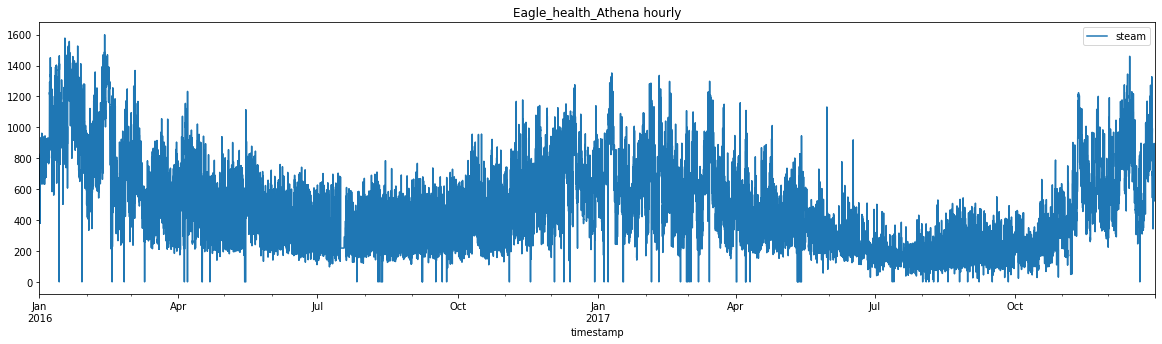

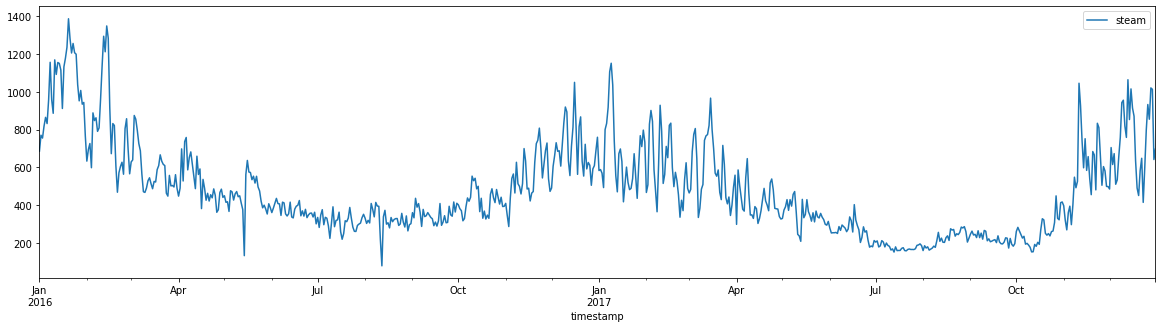

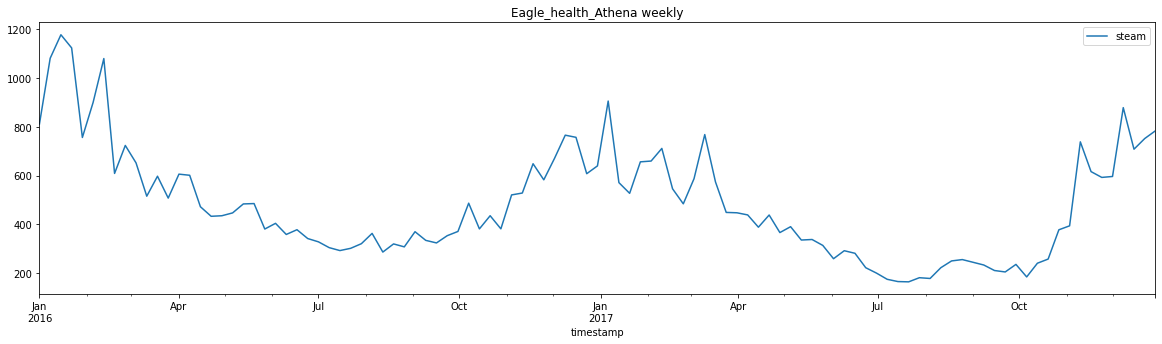

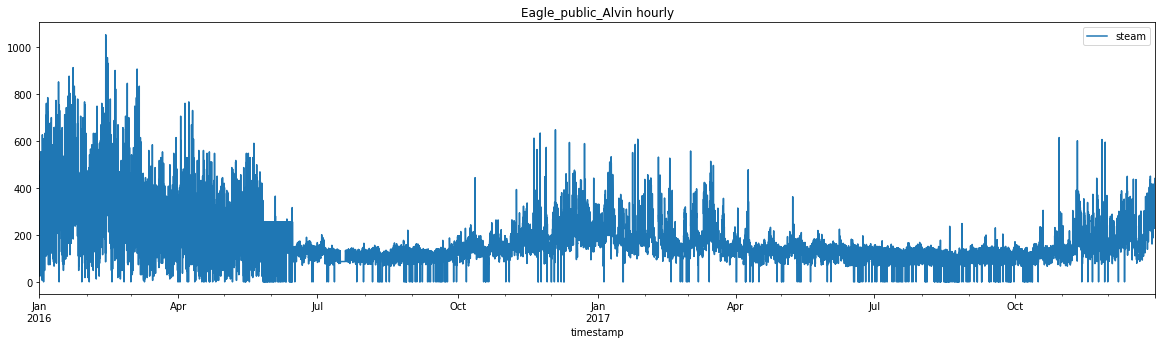

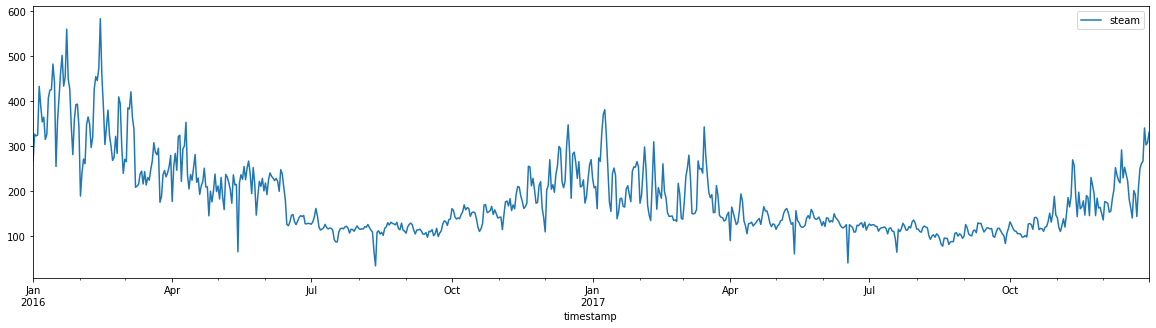

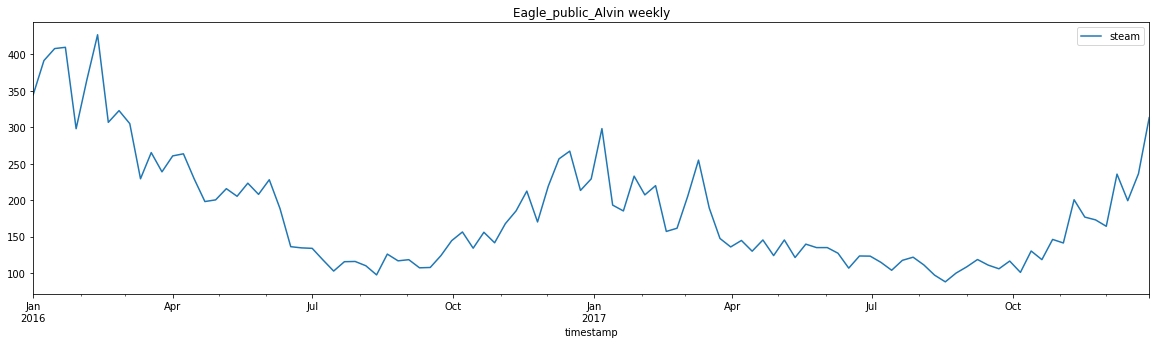

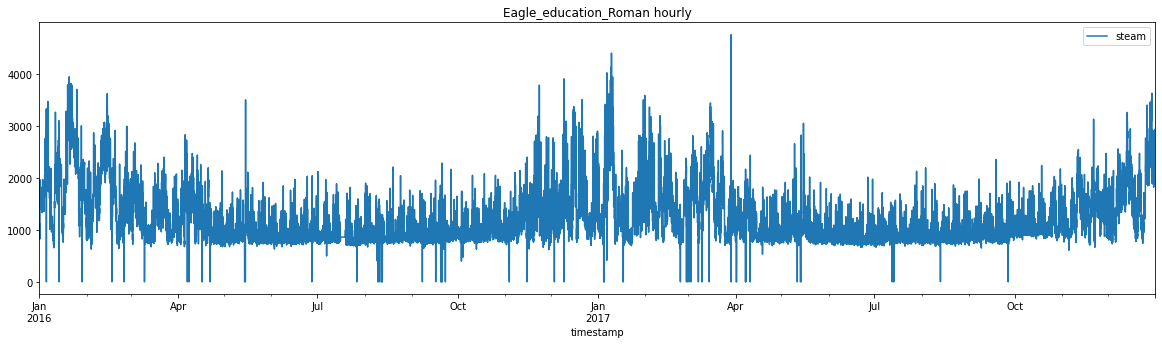

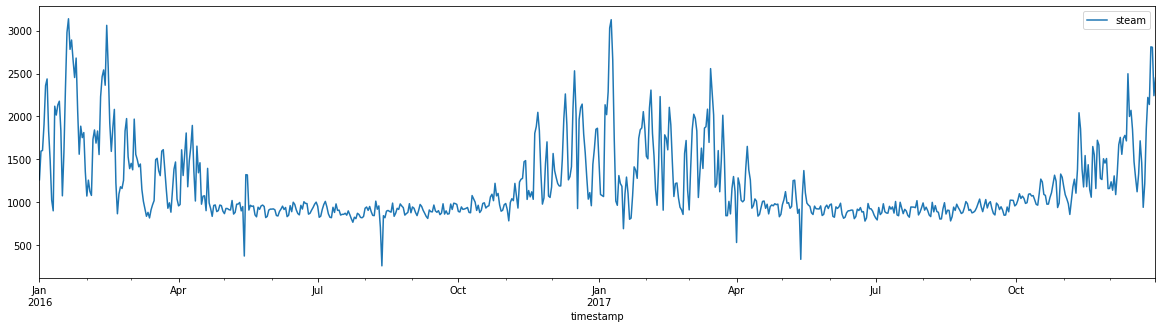

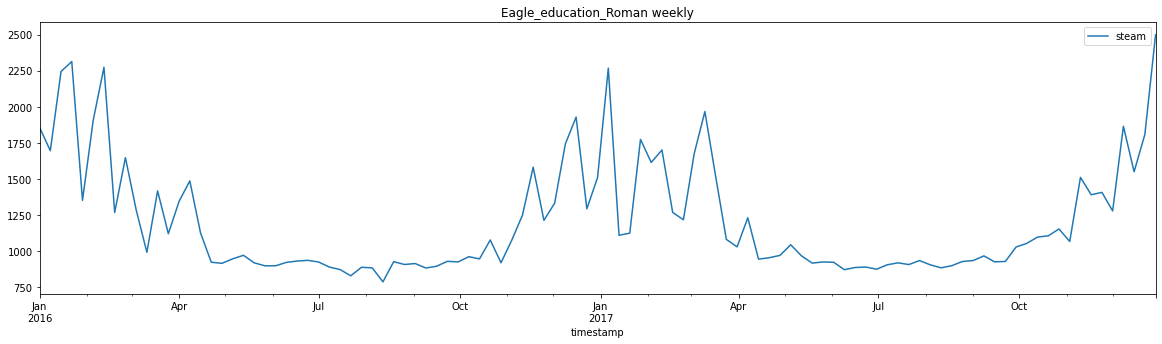

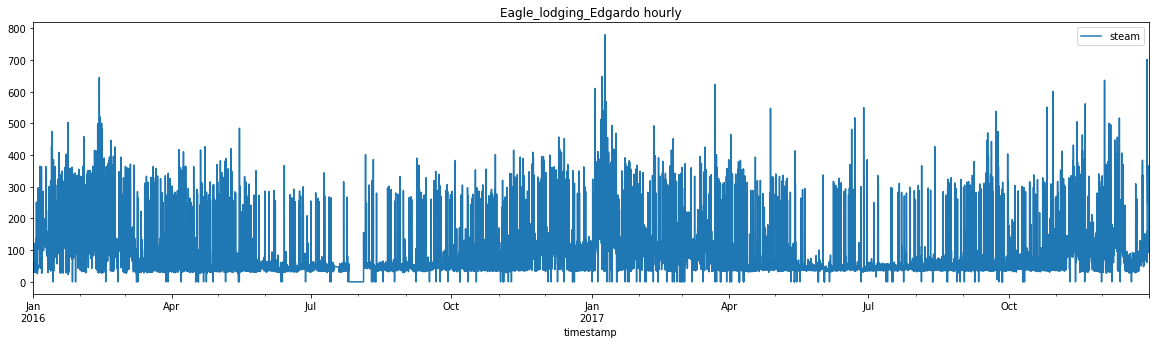

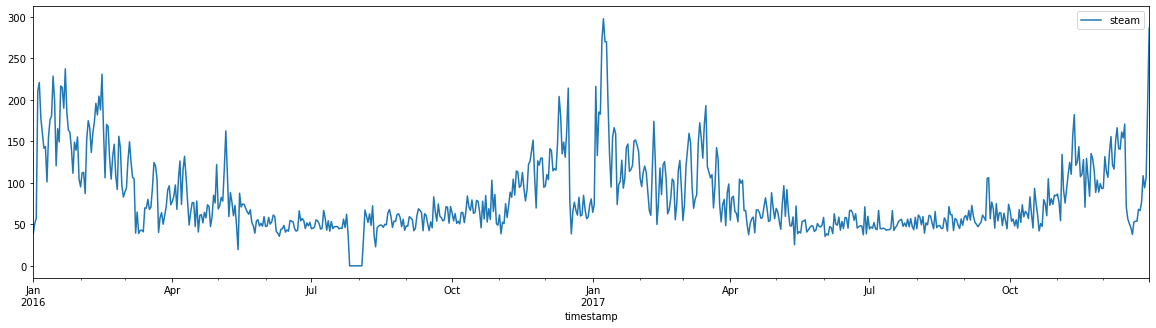

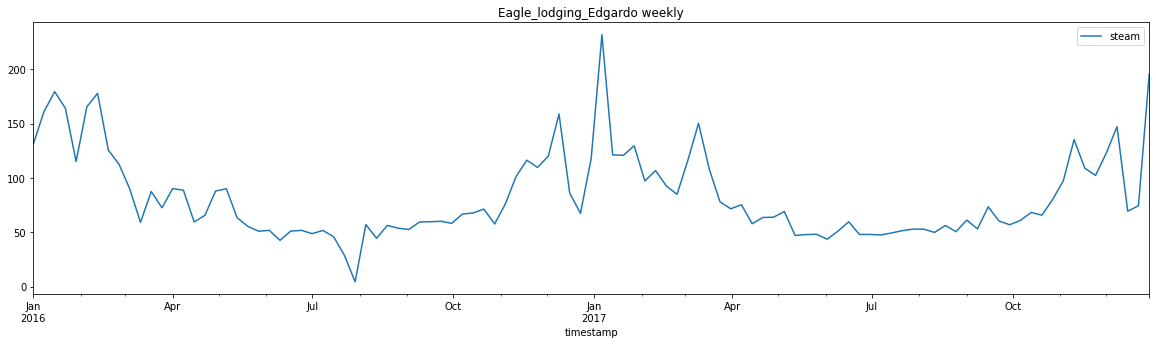

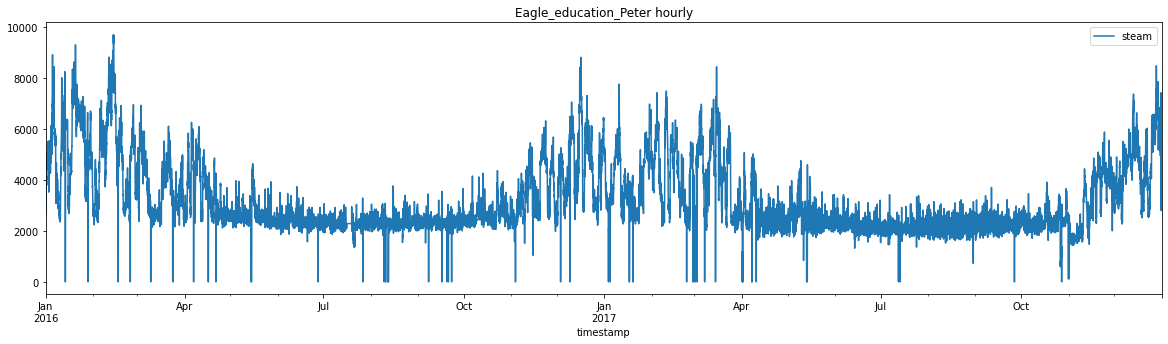

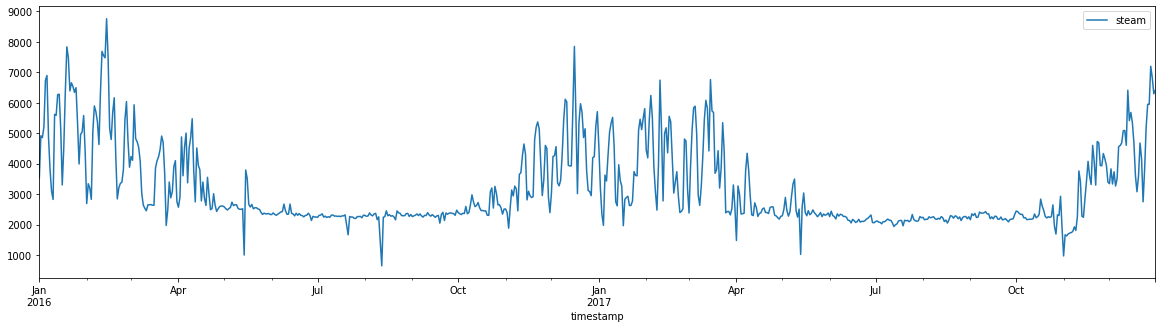

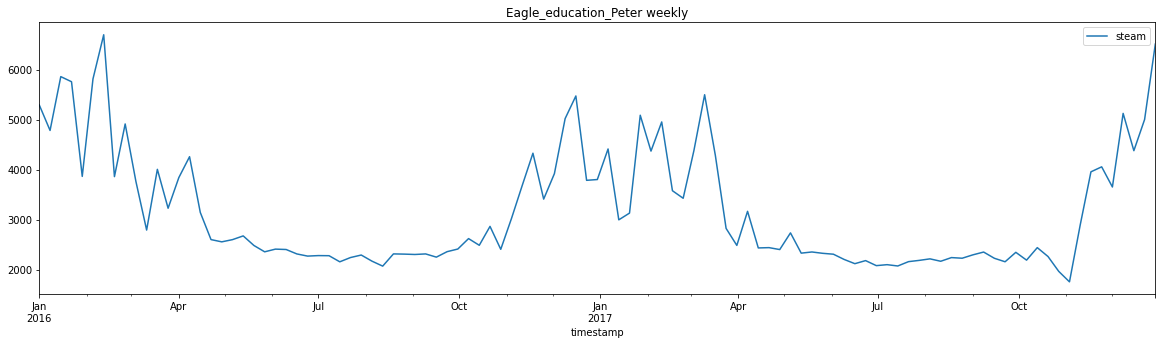

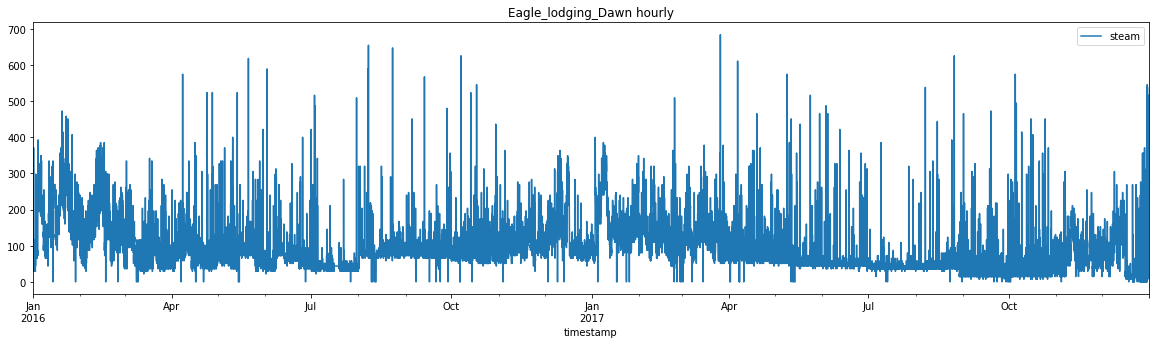

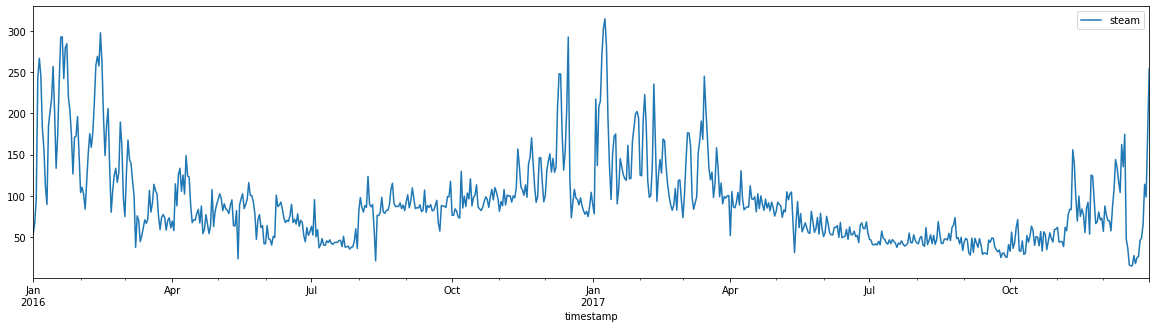

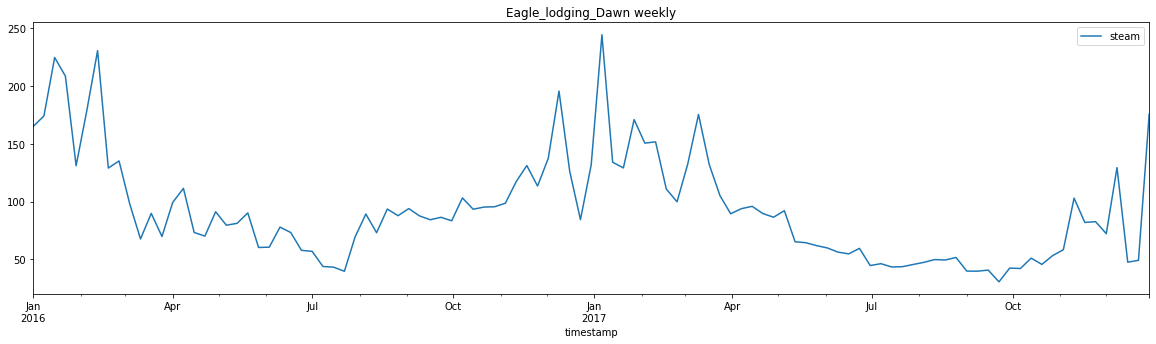

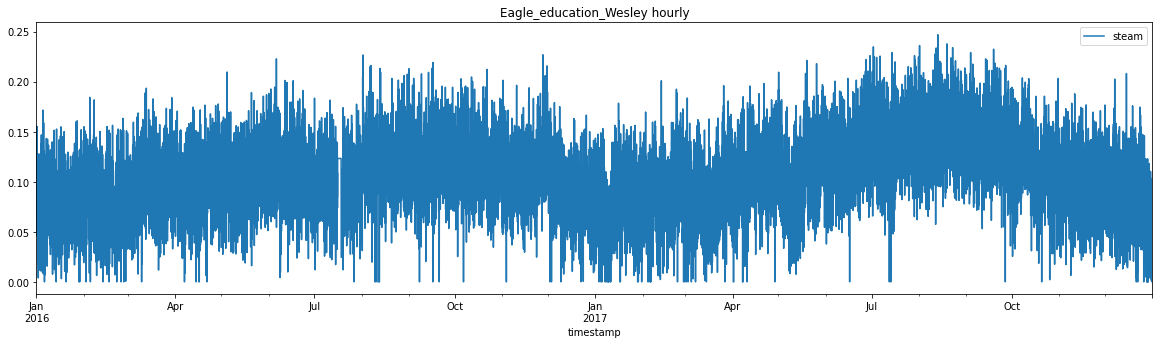

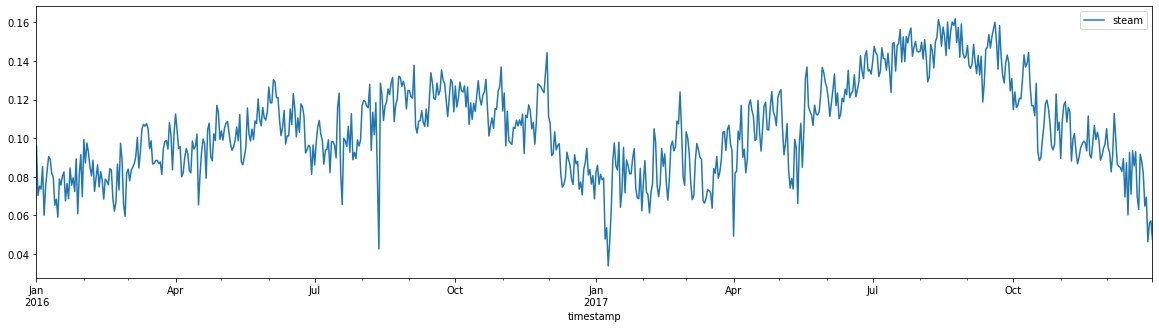

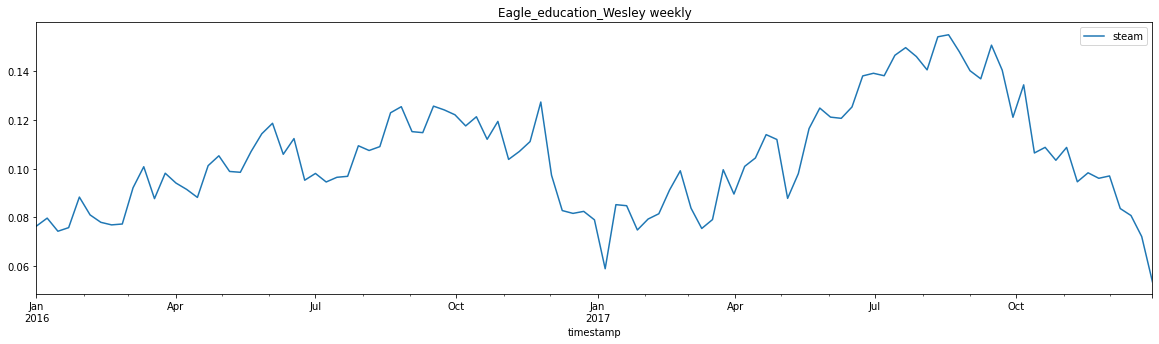

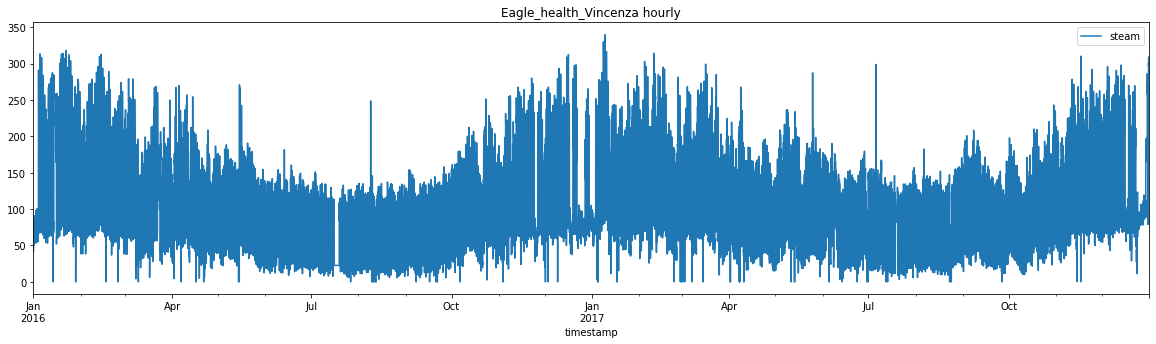

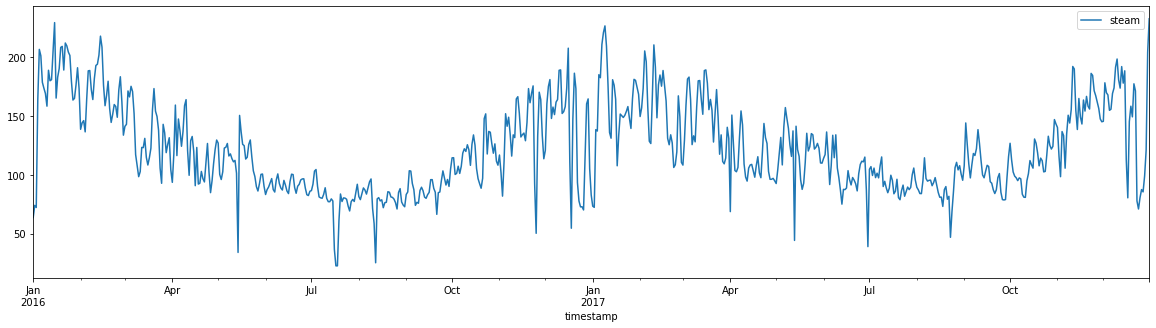

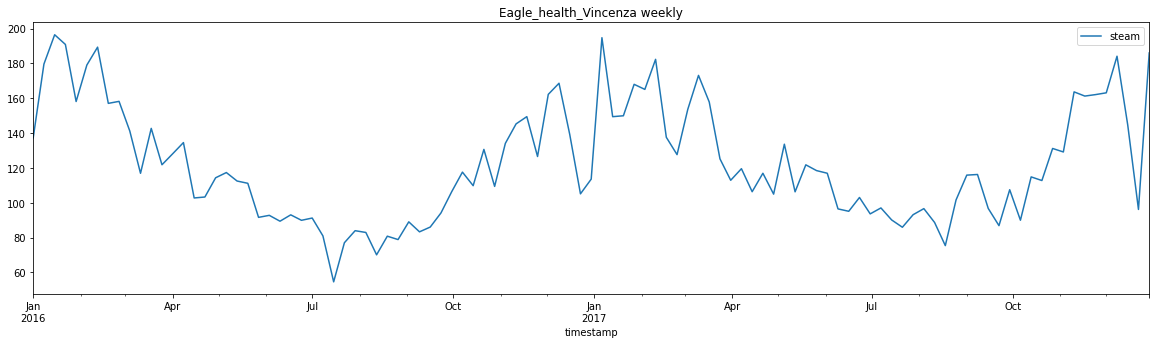

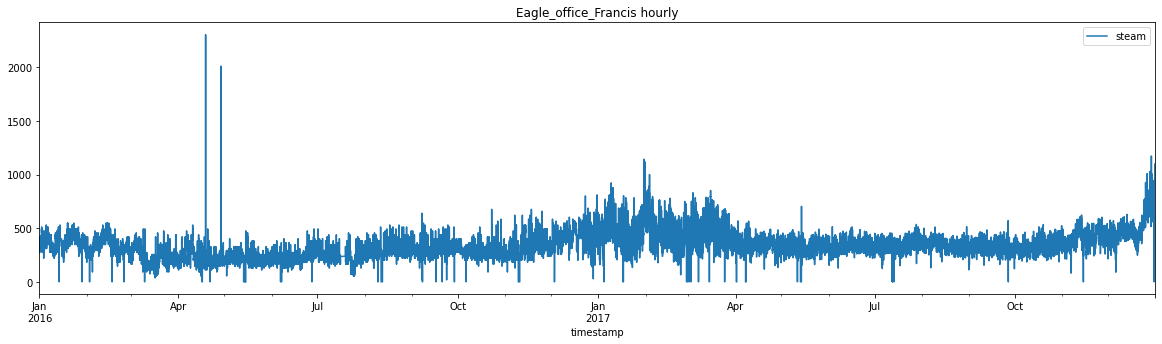

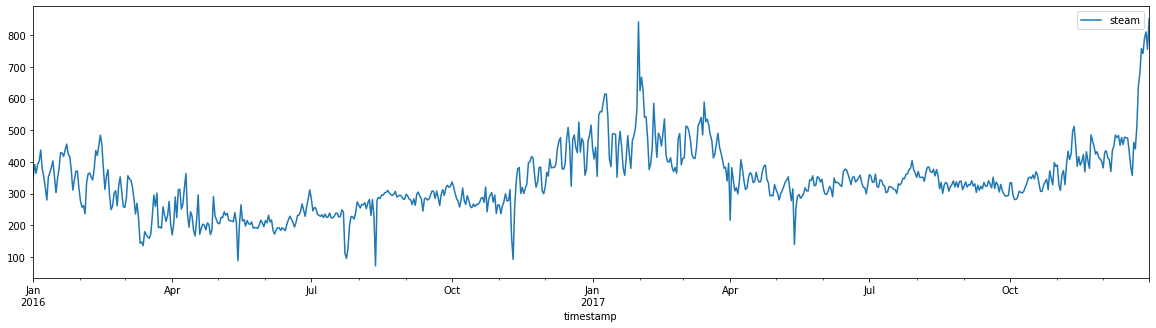

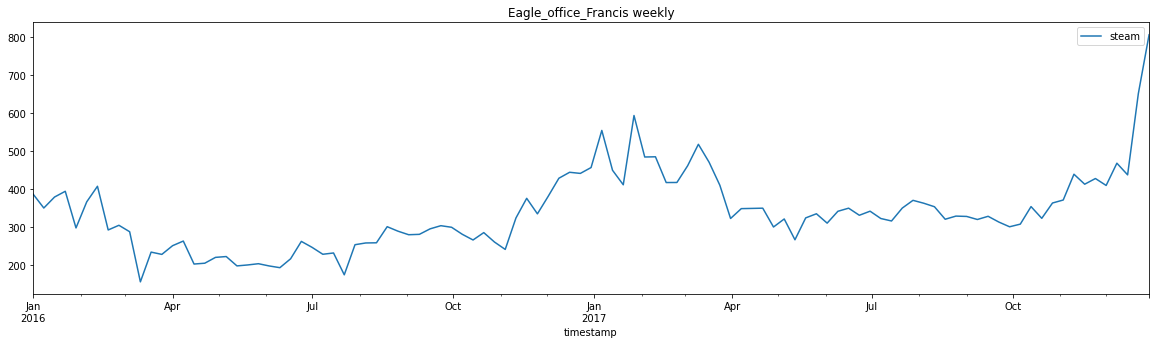

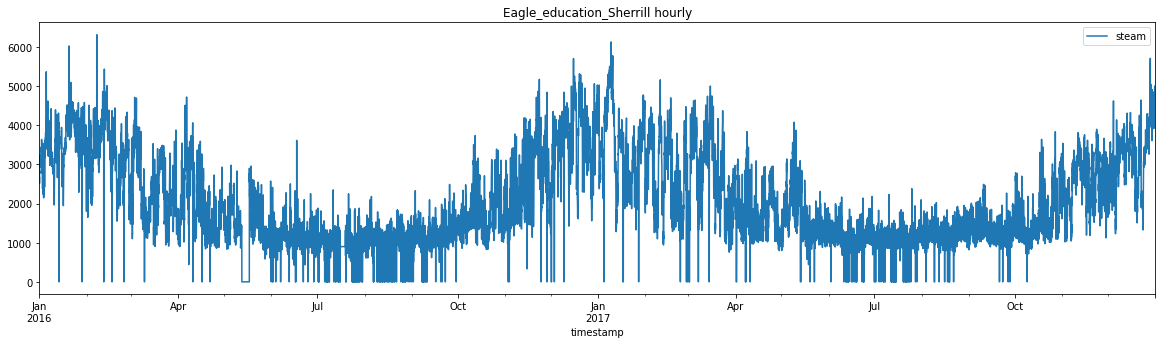

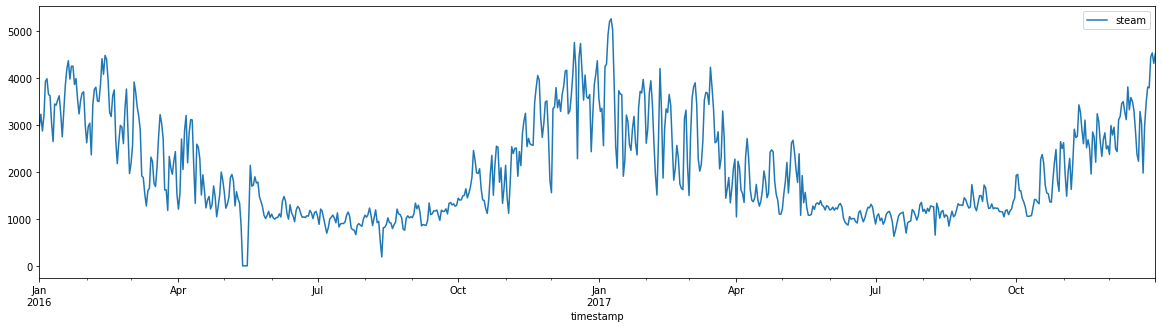

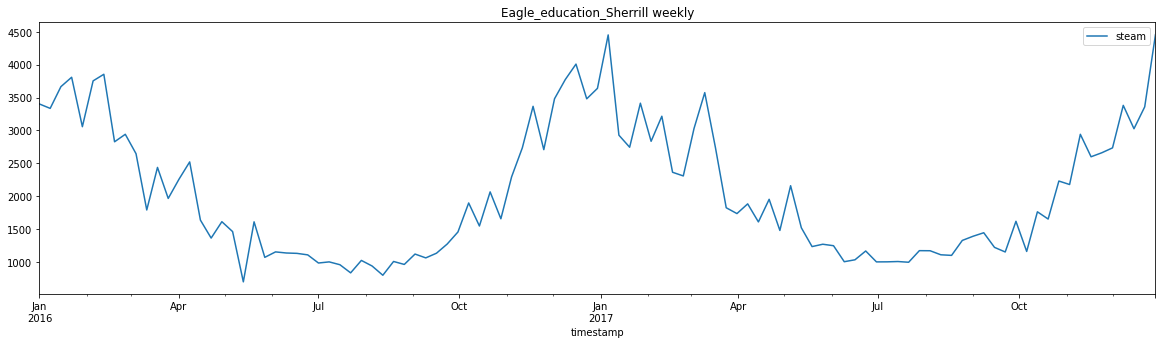

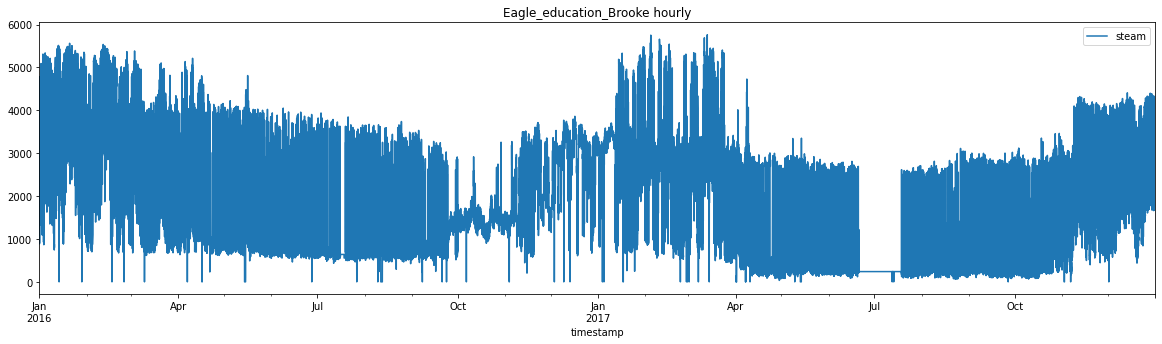

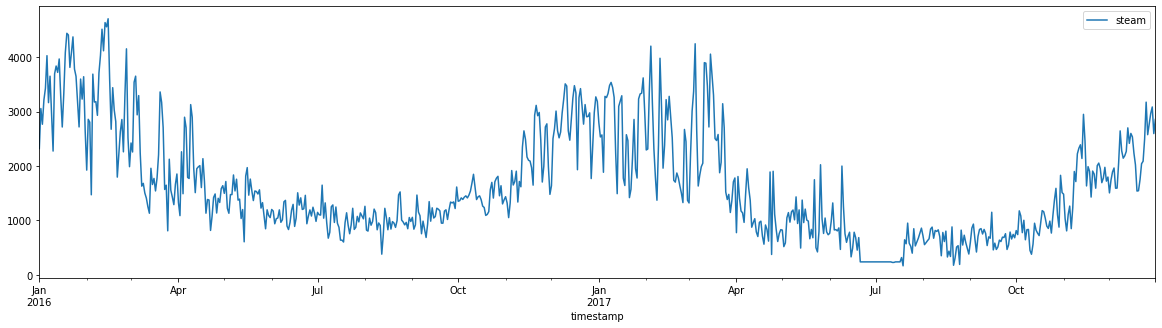

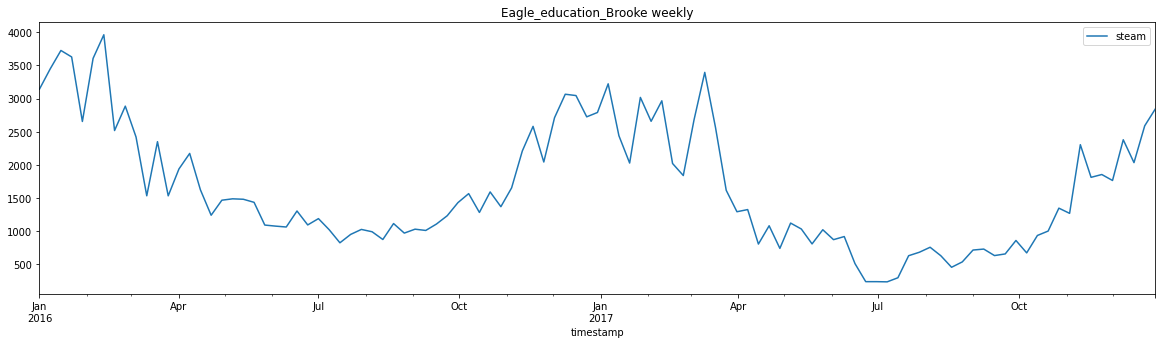

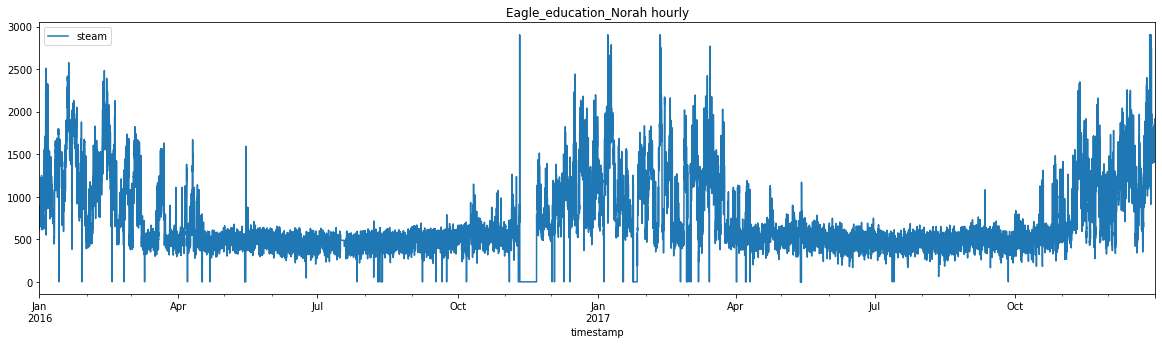

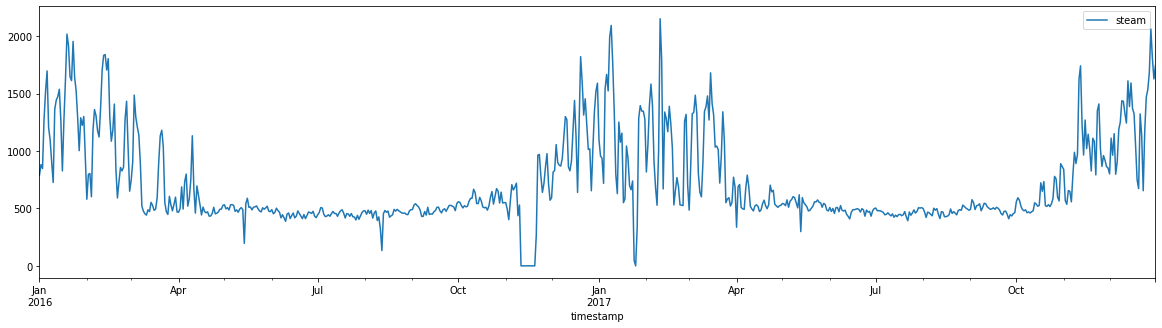

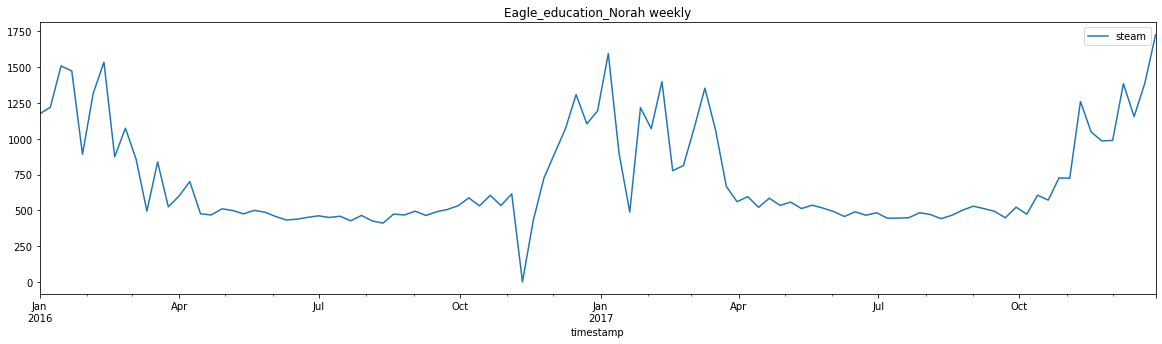

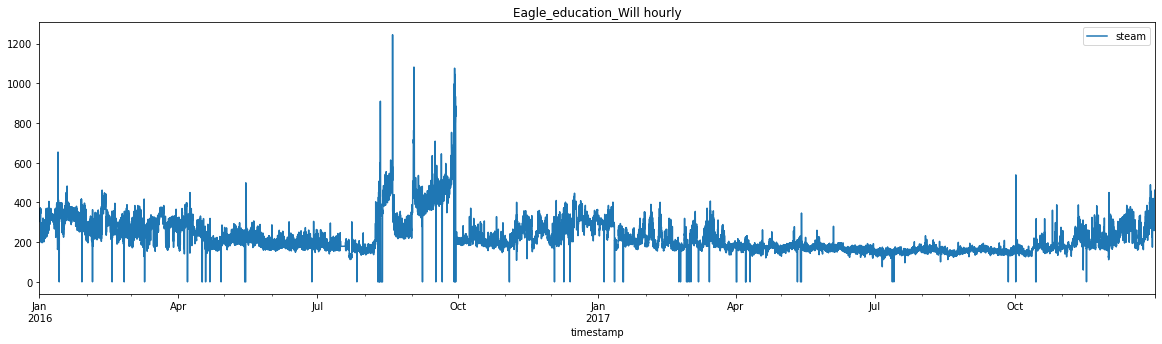

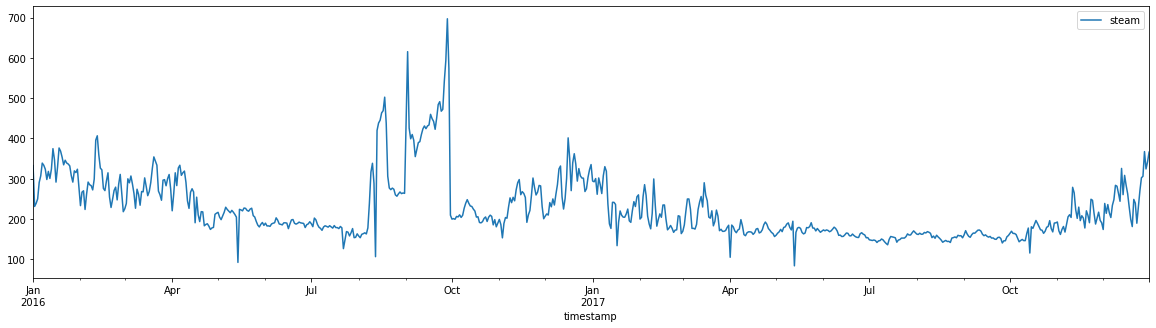

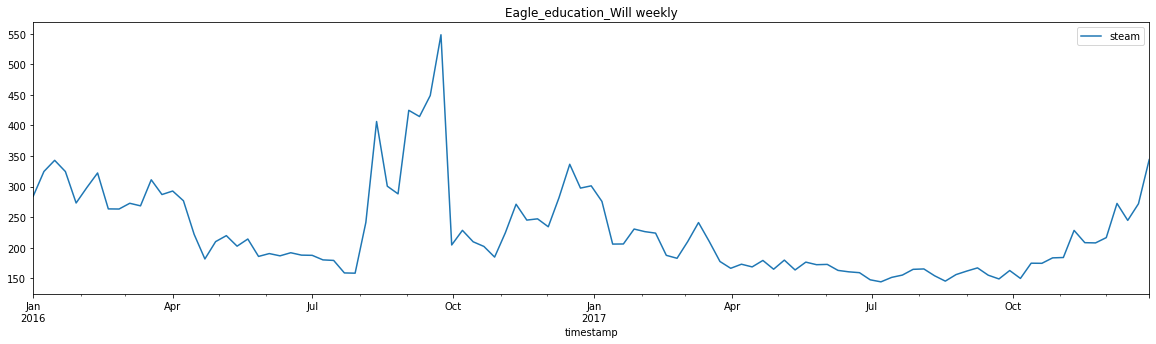

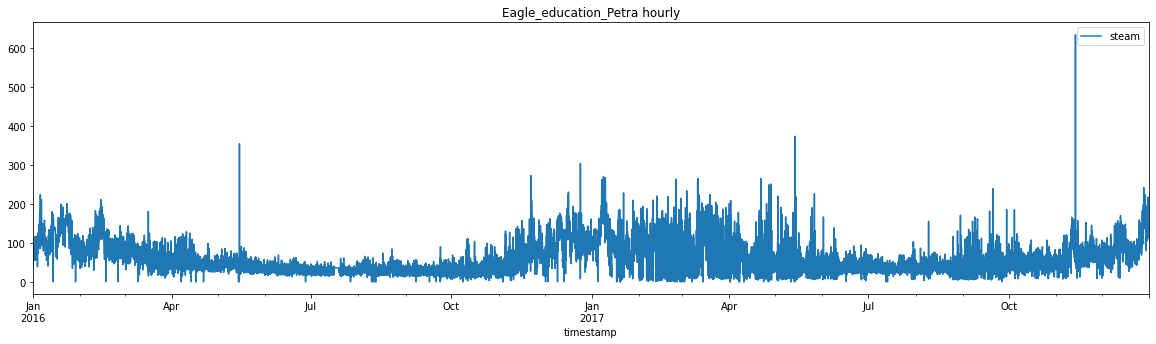

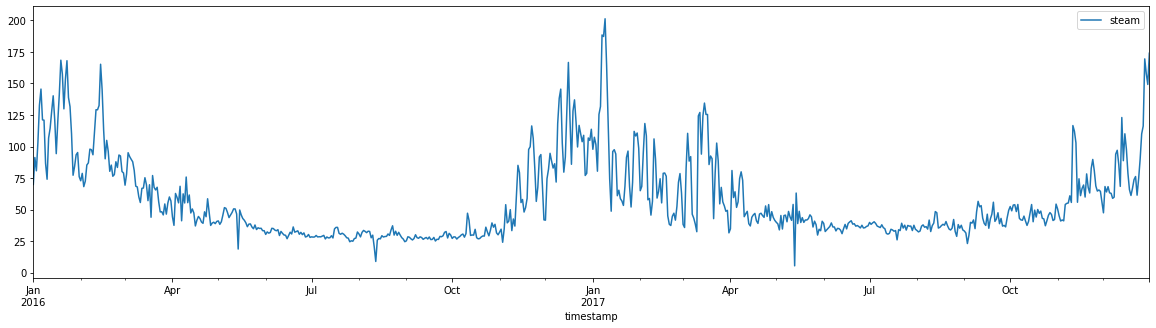

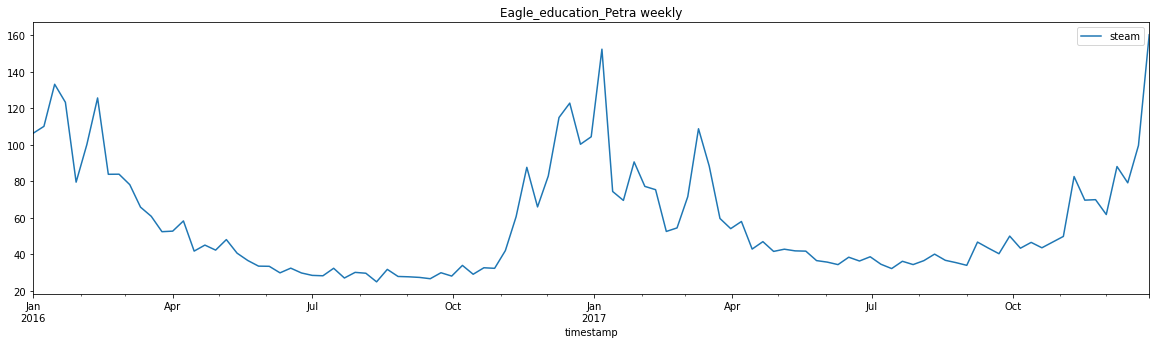

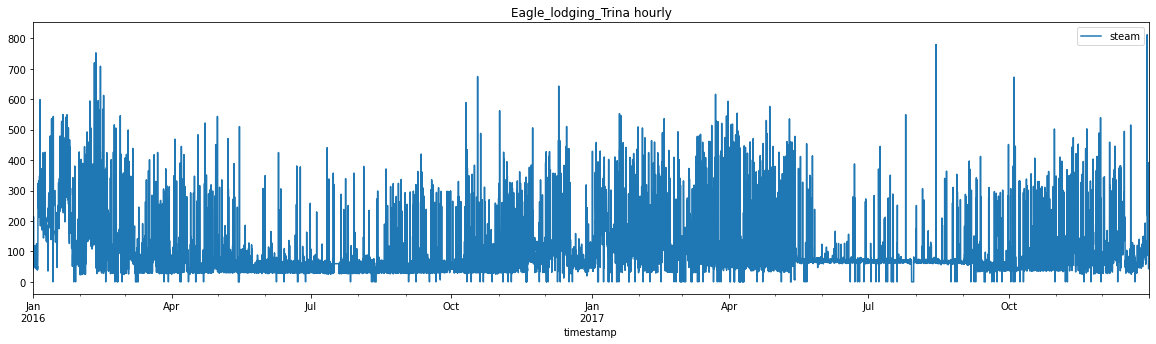

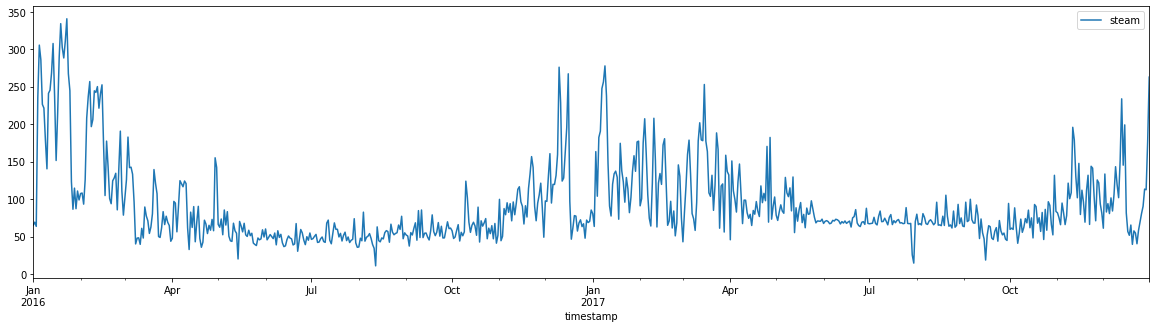

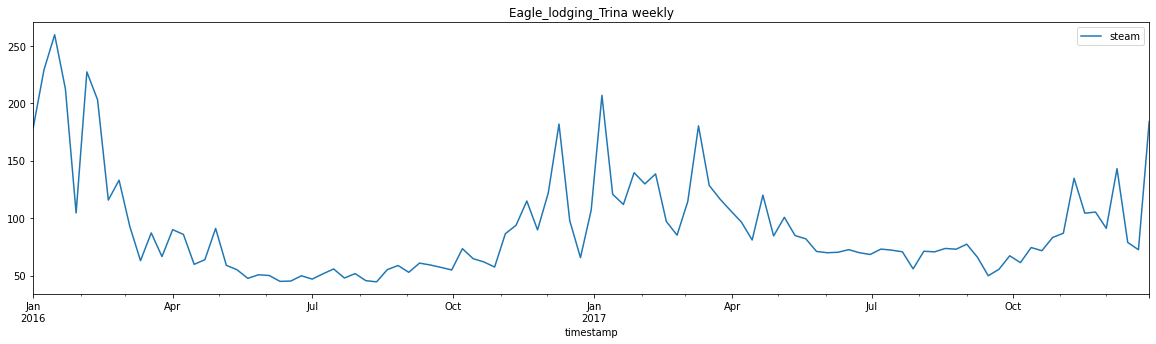

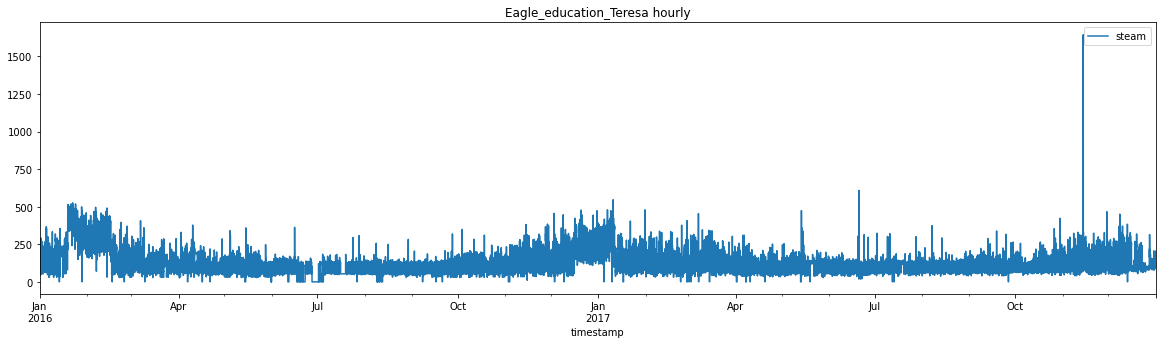

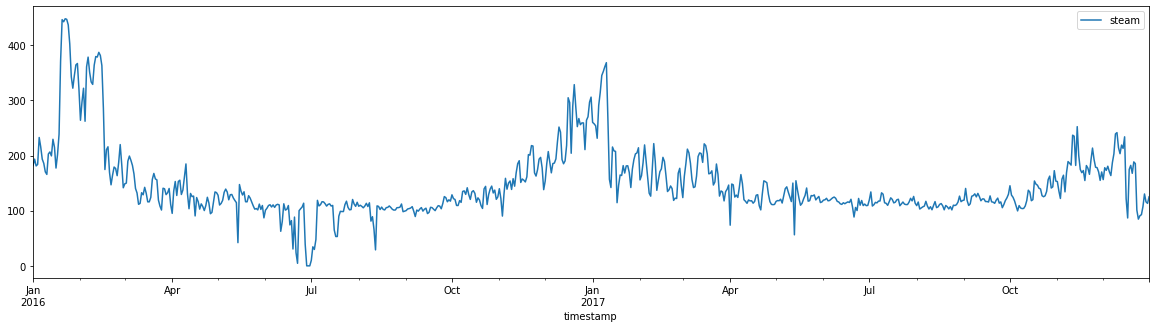

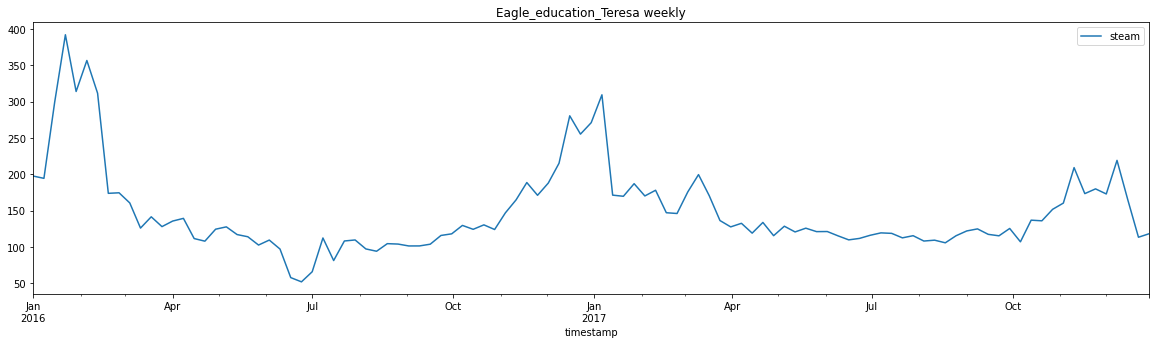

In [14]:
cors = []
# Correlation is low when buildings have many NaN and 0 values.
# We will ignore buildings that have >max bad values.
MAX_BAD = 500 
for BLDG in all_buildings:      
    # Get steam usage for one building.
    bldg_specific_steam = stm_df[[BLDG]]
    # Concatenate steam usage with weather.
    one_bldg_df = pd.concat([bldg_specific_steam,site_specific_weather],axis=1)
    # Drop the site, which is constant (we selected for one site).
    one_bldg_df = one_bldg_df.drop(['site_id'],axis=1)
    # The original steam table used column name = building name.
    # We are processing one building, so rename to the column 'steam'.
    one_bldg_df = one_bldg_df.rename(columns={BLDG : METER})
    # In order to filter bad buildings, count sum of NaN + zero.
    one_bldg_df = one_bldg_df.fillna(0)
    bad = one_bldg_df[METER].isin([0]).sum()
    if bad<=500:
        
        #one_bldg_df = smooth(one_bldg_df)
        one_bldg_df.plot(y=METER,figsize=(20,5))
        plt.title(BLDG+" hourly")
        daily = one_bldg_df.resample("24H").mean() 
        daily.plot(y=METER,figsize=(20,5))
        weekly = one_bldg_df.resample("7D").mean() 
        weekly.plot(y=METER,figsize=(20,5))
        plt.title(BLDG+" weekly")
        plt.show()

## Useful links

Pandas timeseries plot examples.  
https://ourcodingclub.github.io/tutorials/pandas-time-series/